In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
from collections import defaultdict, Counter
import _pickle as pickle
import seaborn as sns
import sys
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
folder = '/content/drive/MyDrive/Tatonetti Lab - Yutaro/covid19_revisions/'

---
## Training/Testing Data

In [ ]:
demographic_matrix = pickle.load(open(folder+'data/new/demographic_matrix.p', 'rb'))
demographic_variables = pickle.load(open(folder+'data/new/demographic_variables.p', 'rb'))
datetime_matrix = pickle.load(open(folder+'data/new/datetime_matrix.p', 'rb'))
datetime_variables = pickle.load(open(folder+'data/new/datetime_variables.p', 'rb'))
diag_matrix = pickle.load(open(folder+'data/new/diag_matrix.p', 'rb'))
diag_variables = pickle.load(open(folder+'data/new/diag_variables.p', 'rb'))
negative_training_set = pickle.load(open(folder+'data/new/negative_training_set.p', 'rb'))
positive_training_set = pickle.load(open(folder+'data/new/positive_training_set.p', 'rb'))
negative_testing_set = pickle.load(open(folder+'data/new/negative_eval_set.p', 'rb'))
positive_testing_set = pickle.load(open(folder+'data/new/positive_eval_set.p', 'rb'))

In [ ]:
full_variable_list = demographic_variables + datetime_variables[:-1] + diag_variables
len(full_variable_list)

1637

In [ ]:
full_matrix = []

for pat_enc_csn_id in positive_training_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix.append(to_add)

for pat_enc_csn_id in negative_training_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix.append(to_add)

In [ ]:
covid_non_covid_visits = [1 for i in range(len(positive_training_set))] + [0 for i in range(len(negative_training_set))]
len(covid_non_covid_visits), Counter(covid_non_covid_visits)

(9340, Counter({1: 4670, 0: 4670}))

In [ ]:
full_matrix_testing = []

for pat_enc_csn_id in positive_testing_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix_testing.append(to_add)

for pat_enc_csn_id in negative_testing_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix_testing.append(to_add)

In [ ]:
covid_non_covid_visits_testing = [1 for i in range(len(positive_testing_set))] + [0 for i in range(len(negative_testing_set))]
len(covid_non_covid_visits_testing), Counter(covid_non_covid_visits_testing)

(9340, Counter({1: 4670, 0: 4670}))

In [ ]:
full_matrix = np.array(full_matrix)
full_matrix_testing = np.array(full_matrix_testing)
full_matrix.shape, full_matrix_testing.shape

((9340, 1637), (9340, 1637))

## Running RF

In [ ]:
#run random forest with same parameters as original paper
rf = RandomForestClassifier(n_estimators=190, random_state=1, oob_score=True, max_depth=69)
rf.fit(full_matrix, covid_non_covid_visits)
estimate_covid_oob = rf.oob_decision_function_[:,1]
estimate_covid = rf.predict_proba(full_matrix)[:,1]
testing_covid = rf.predict_proba(full_matrix_testing)[:,1]

In [ ]:
#check we get same performance - we do!
false_positive_rate, true_positive_rate, thresholds = roc_curve(covid_non_covid_visits, estimate_covid_oob)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('training_oob_auroc',roc_auc)
false_positive_rate, true_positive_rate, thresholds = roc_curve(covid_non_covid_visits, estimate_covid)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('training_auroc',roc_auc)
false_positive_rate, true_positive_rate, thresholds = roc_curve(covid_non_covid_visits_testing, testing_covid)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('testing_auroc',roc_auc)

training_oob_auroc 0.8957386892507186
training_auroc 0.9866616381385582
testing_auroc 0.8958289276396334


## Run Calibration

In [ ]:
#compare calibration methods (Jason recommends isotonic, but check all just in case)
for method in ['isotonic', 'sigmoid']:
  calibrated_clf = CalibratedClassifierCV(rf, method = method, cv='prefit')
  calibrated_clf.fit(full_matrix_testing, covid_non_covid_visits_testing)
  calibrated_prob = calibrated_clf.predict_proba(full_matrix_testing)
  cal_prob = [i[1] for i in calibrated_prob]
  false_positive_rate, true_positive_rate, thresholds = roc_curve(covid_non_covid_visits_testing, cal_prob)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  loss = brier_score_loss(covid_non_covid_visits_testing, cal_prob)
  print('auroc for method : {} is '.format(method),roc_auc)
  print('brier loss for method : {} is '.format(method), loss)

auroc for method : isotonic is  0.897208226916534
brier loss for method : isotonic is  0.12917689742202765
auroc for method : sigmoid is  0.8958289276396334
brier loss for method : sigmoid is  0.13227211099164543


In [ ]:
#assessment of calibration (using isotonic calibration)
calibrated_clf = CalibratedClassifierCV(rf, method = 'isotonic', cv='prefit')
calibrated_clf.fit(full_matrix_testing, covid_non_covid_visits_testing)
calibrated_prob = calibrated_clf.predict_proba(full_matrix_testing)
cal_prob = [i[1] for i in calibrated_prob]
false_positive_rate, true_positive_rate, thresholds = roc_curve(covid_non_covid_visits_testing, cal_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

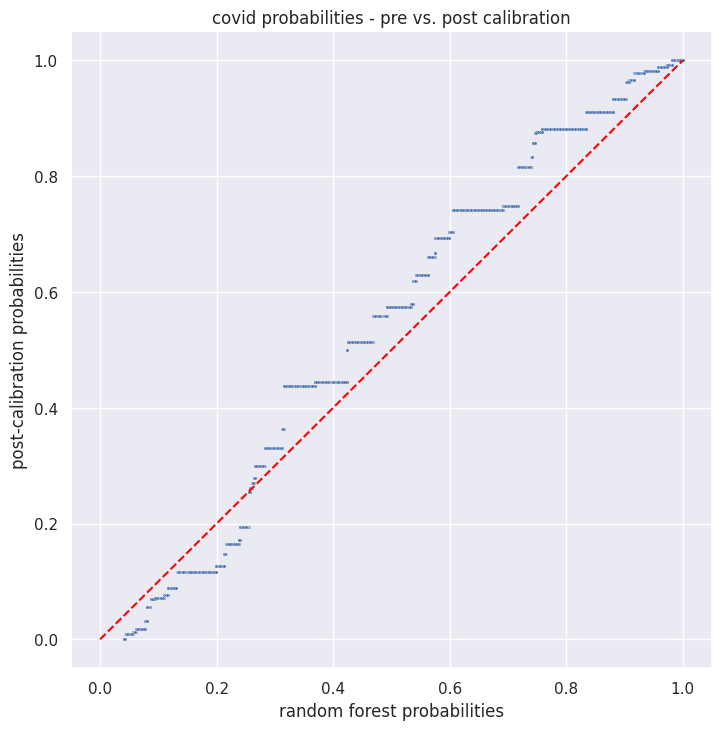

In [ ]:
sns.set(rc={'figure.figsize':(8.27,8.27)})
sns.scatterplot(y=cal_prob, x=testing_covid, s = 5, c = 'b')
sns.lineplot(x=[0,1], y=[0,1], c='red', linestyle='--')
plt.xlabel('random forest probabilities')
plt.ylabel('post-calibration probabilities')
plt.title('covid probabilities - pre vs. post calibration')
plt.show()

In [ ]:
#binned probability comparison
bin_df = pd.DataFrame()
bin_df['actual'] = covid_non_covid_visits_testing
bin_df['rf_prob'] = testing_covid
bin_df['calibration_prob'] = cal_prob

In [ ]:
rf_bins = bin_df[['actual', 'rf_prob']]
rf_bins['bin'] = pd.qcut(rf_bins['rf_prob'], q=20, labels=False, precision=0)
rf_bins = rf_bins.groupby('bin').agg(list).reset_index()
rf_bins['positive_fraction'] = rf_bins.actual.apply(lambda x: np.mean(x))
rf_bins['predicted_fraction'] = rf_bins.rf_prob.apply(lambda x: np.mean(x))

In [ ]:
cal_bins = bin_df[['actual', 'calibration_prob']]
cal_bins['bin'] = pd.qcut(cal_bins['calibration_prob'], q=20, labels=False, precision=0)
cal_bins = cal_bins.groupby('bin').agg(list).reset_index()
cal_bins['positive_fraction'] = cal_bins.actual.apply(lambda x: np.mean(x))
cal_bins['predicted_fraction'] = cal_bins.calibration_prob.apply(lambda x: np.mean(x))

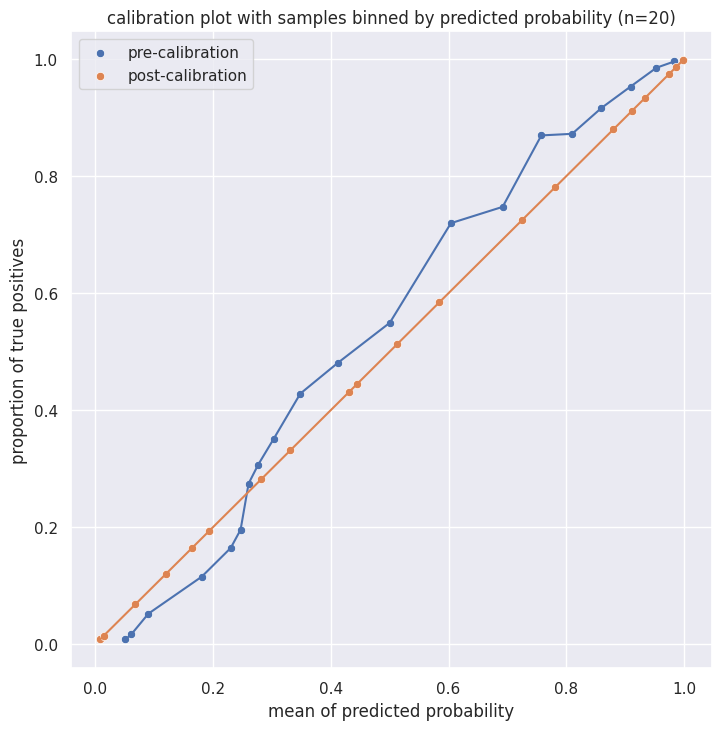

In [ ]:
sns.scatterplot(x=rf_bins['predicted_fraction'], y=rf_bins['positive_fraction'], label = 'pre-calibration')
sns.lineplot(x=rf_bins['predicted_fraction'], y=rf_bins['positive_fraction'])
sns.scatterplot(x=cal_bins['predicted_fraction'], y=cal_bins['positive_fraction'], label = 'post-calibration')
sns.lineplot(x=cal_bins['predicted_fraction'], y=cal_bins['positive_fraction'])
plt.xlabel('mean of predicted probability')
plt.ylabel('proportion of true positives')
plt.title('calibration plot with samples binned by predicted probability (n=20)')
plt.show()

In [ ]:
pickle.dump(cal_prob, open(folder+'data/testing_calibrated_prob.p', 'wb'))

In [ ]:
pickle.dump(calibrated_clf, open(folder+'data/calibrated_model.p', 'wb'))
pickle.dump(rf, open(folder+'data/rf_model.p', 'wb'))